In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool

from typing import Annotated, Any
from pydantic import BaseModel, Field

import operator
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [48]:
# ツール定義

@tool
def addition(x: int, y: int) -> int:
    """
    2つのint型の値を引数で受け取り、足し算の結果をint型で返す

    Args:
        x: int  1つ目のint型の引数
        y: int  2つ目のint型の引数

    Returns:
        int: x + y
    """
    return x + y


@tool
def multiply(x: int, y: int) -> int:
    """
    2つのint型の値を引数で受け取り、掛け算の結果をint型で返す

    Args:
        x: int  1つ目のint型の引数
        y: int  2つ目のint型の引数

    Returns:
        int: x * y
    """
    return x * y


# @tool
# def spec_designer(spec_contents: str) -> str:
#     """
#     要求仕様書に記載するコンテンツ情報を受け取り、
#     フォーマット化された要求仕様書のテキストを返す

#     Args:
#         spec_contents: str  要求仕様書に盛り込むコンテンツ情報

#     Returns:
#         str:  要求仕様書のフォーマット
#     """
#     return spec_contents



@tool
def file_writer(fileName: str, text :str) -> bool:
    """
    ファイル名fileNameのファイルにテキストtextを書き込む

    Args:
        fileName: str  作成するファイル名
        text :str  書き込むテキスト

    Returns:
        bool: 書き込み成功したらTrue, そうでなければFalse
    """
    result = True
    try:
        with open(fileName, "w", encoding="utf-8") as f:
            f.write(text)
    except:
        result = False

    return result


tools = [addition, multiply, file_writer]

In [3]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

## CoT -> Tool -> Observe -> Evalというステップ

In [4]:
class GlobalState(BaseModel):
    current_agent: str = Field(default="", description="現在のエージェント")
    # user_request: str = Field(default="", description="ユーザの要求")
    messages: Annotated[list, add_messages] = Field(
        default=[],
        description="メッセージ履歴"
    )


In [ ]:
class ReActAgent():
    """
    ReActエージェントクラス
    """

    def __init__(self, llm: ChatOpenAI, tools, agent_name):
        self.llm=llm.bind_tools(tools)
        self.tools = tools
        self.agent_name = agent_name
        self.graph = self._create_graph()

        self.user_request = None
        self.run_log = ""

    def _create_graph(self):

        # ノード名称
        ini = f"{self.agent_name}-Init"
        cot = f"{self.agent_name}-CoT"
        obs = f"{self.agent_name}-Obs"
        evl = f"{self.agent_name}-Eval"
        tls = f"{self.agent_name}-Tools"

        # ノード定義
        def Init(state: GlobalState) -> dict[Any, str]:
            print(f"Initialization")

            messages = state.messages
            self.user_request = messages[-1].content
            
            return {"current_agent": self.agent_name}


        def CoT(state: GlobalState) -> dict[Any, str]:
            print(f"{cot} now...")

            messages = state.messages

            print(self.user_request)

            response = self.llm.invoke(messages)
            # response = AIMessage(content="お腹が空いたなあ。")

            print(response.content)

            return {"messages": [response]}
        

        def Observation(state: GlobalState) -> dict[Any, str]:
            print(f"{obs} now...")

            # ツールの実行結果を応答する
            messages = state.messages
            response = self.llm.invoke(messages)

            print(response)

            
            return {"messages": [response]}
        

        def Evaluation(state: GlobalState) -> dict[Any, str]:
            print(f"{evl} now...")

            messages = state.messages

            prompt = PromptTemplate.from_template(\
"""
あなたは文章の推敲エージェントです。
以下のユーザ要求に対して、AIエージェントの応答が適切か判断してください。
ツールは使用しないこと。
ユーザ要求：'{user_request}'
AIエージェント応答：'{response}'
""")
            
            prompt_value = prompt.invoke({"user_request": self.user_request, "response": messages[-1].content})
            print(prompt_value.text)

            answer = self.llm.invoke(prompt_value)

            print(answer.content)
            
            return {"messages": [ HumanMessage(content=prompt_value.text), answer ]}
        
        tool_node = ToolNode(tools=self.tools)


        # グラフ構築
        workflow = StateGraph(GlobalState)
        workflow.add_node(ini, Init)
        workflow.add_node(cot, CoT)
        workflow.add_node(obs, Observation)
        workflow.add_node(evl, Evaluation)
        workflow.add_node(tls, tool_node)

        workflow.add_edge(START, ini)
        workflow.add_edge(ini, cot)
        workflow.add_conditional_edges(cot, tools_condition, {
            "tools": tls,
            END: evl
        })
        workflow.add_edge(tls, obs)
        workflow.add_conditional_edges(obs, tools_condition, {
            "tools": tls,
            END: evl
        })
        workflow.add_edge(evl, END)

        return workflow.compile()
    

    def run(self, state: GlobalState, debug: bool = False):
        """エージェント単体実行"""
        self.run_log = self.graph.invoke(state, debug=debug)



In [119]:
x_agent = ReActAgent(llm, tools, "X")

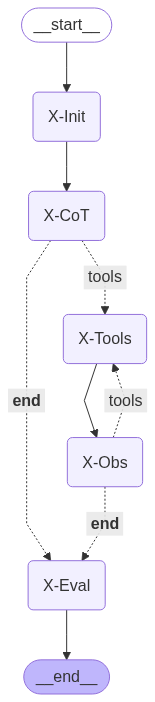

In [110]:
from IPython.display import Image, display
display(Image(x_agent.graph.get_graph().draw_mermaid_png()))


In [114]:
# stat = GlobalState(messages=["こんにちは。"])
# stat = GlobalState(messages=["123掛ける456を計算してください。"])
stat = GlobalState(messages=["321+654を計算してください。"])

x_agent.run(stat)
x_agent.run_log["messages"]


Initialization
X-CoT now...
321+654を計算してください。

X-Obs now...
content='321 + 654 の計算結果は 975 です。' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 321, 'total_tokens': 336, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'finish_reason': 'stop', 'logprobs': None} id='run-485c3e5a-b8b0-40c1-ae0a-4fe4da2b1226-0' usage_metadata={'input_tokens': 321, 'output_tokens': 15, 'total_tokens': 336}
X-Eval now...

あなたは文章の推敲エージェントです。
以下のユーザ要求に対して、AIエージェントの応答が適切か判断してください。
ツールは使用しないこと。
ユーザ要求：'321+654を計算してください。'
AIエージェント応答：'321 + 654 の計算結果は 975 です。'

AIエージェントの応答は適切です。321 + 654 の計算結果は確かに 975 です。


[HumanMessage(content='321+654を計算してください。', additional_kwargs={}, response_metadata={}, id='fd751efb-0665-4320-948c-2caa7d37f5de'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1AhE4nVI4I2cIijT5tywQqY9', 'function': {'arguments': '{"x":321,"y":654}', 'name': 'addition'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 295, 'total_tokens': 313, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3cc2c240-39bd-49c4-a78b-bbe999561bbf-0', tool_calls=[{'name': 'addition', 'args': {'x': 321, 'y': 654}, 'id': 'call_1AhE4nVI4I2cIijT5tywQqY9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 295, 'output_tokens': 18,

## Agent部分とTool部分だけのシンプルな構造にする

In [4]:
class GlobalState(BaseModel):
    current_agent: str = Field(default="", description="現在のエージェント")
    user_request: str = Field(default="", description="ユーザの要求")
    
    messages: Annotated[list, add_messages] = Field(
        default=[],
        description="メッセージ履歴"
    )
    num_thought: int = Field(default=0, description="エージェントの思考回数")
    num_trial: int = Field(default=0, description="タスクトライアル回数")


In [49]:
class ReActAgent():
    """
    ReActエージェントクラス
    """

    def __init__(self, llm: ChatOpenAI, tools, agent_name):
        self.llm=llm.bind_tools(tools)
        self.tools = tools
        self.agent_name = agent_name
        self.graph = self._create_graph()

        self.run_log = ""
        self.log_messages = []

        self.first_thought = None

        self.system_prompt = \
"""
あなたは優秀なAIエージェントです。
"""
        self.task_prompt = \
"""
ユーザの要求に対して思考と行動を行ってください。
ユーザの要求：`{user_request}`
"""

    def _create_graph(self):

        # ノード名称
        ini = f"{self.agent_name}-Init"
        rea = f"{self.agent_name}-Reasoning"
        act = f"{self.agent_name}-Action"

        # ノード定義
        def Init(state: GlobalState) -> dict[Any, str]:
            print(f"Initialization")
            
            system_prompt = SystemMessage(content=self.system_prompt)

            prompt = PromptTemplate.from_template(self.task_prompt)
            prompt_value = prompt.invoke({"user_request": state.user_request})

            print(prompt_value)

            task_prompt = HumanMessage(content=prompt_value.text)

            return {"current_agent": self.agent_name, "messages": [system_prompt, task_prompt], "num_thought": 1}


        def Reasoning(state: GlobalState) -> dict[Any, str]:

            print("="*100)
            print(f"{rea} now... 思考{state.num_thought}回目")

            
            if state.num_thought == 1: # 思考1回目のとき
                thought_prompt = HumanMessage(content=\
"""
まずは最初に取るべき行動を思考し、行動を実行してください。
思考の結果は以下の形式で提示してください。
```
質問：ユーザの要望
思考：最初の行動の計画
行動：実行すべきアクション。ツールがあれば使用する
行動の入力：アクションへの入力
```
""")
            else: # 思考2回目以降
                thought_prompt= HumanMessage(content=\
"""
行動の結果を観察し、観察から次の行動を思考して行動を実行してください。
思考の結果は以下の形式で提示してください。
```
観察：行動の結果
思考：これまでの行動と観察を受けて、次に取る行動の計画
行動：実行すべきアクション。ツールがあれば使用する
行動の入力：アクションへの入力
```
""")
                
            messages = state.messages
            messages.append(thought_prompt)
            thought = self.llm.invoke(messages) # thoughtする


            if self.first_thought is None:
                self.first_thought = thought

            print(thought.content)

            return {"messages": [thought_prompt, thought], "num_thought": state.num_thought+1}


        # ツールノード（Action）                
        tool_node = ToolNode(tools=self.tools)


        # グラフ構築
        workflow = StateGraph(GlobalState)
        workflow.add_node(ini, Init)
        workflow.add_node(rea, Reasoning)
        workflow.add_node(act, tool_node)

        workflow.add_edge(START, ini)
        workflow.add_edge(ini, rea)
        workflow.add_conditional_edges(rea, tools_condition, {
            "tools": act,
            END: END
        })
        workflow.add_edge(act, rea)

        return workflow.compile()
    

    def run(self, state: GlobalState, debug: bool = False):
        """エージェント単体実行"""
        self.run_log = self.graph.invoke(state, debug=debug)


In [50]:
y_agent = ReActAgent(llm, tools, "Y")

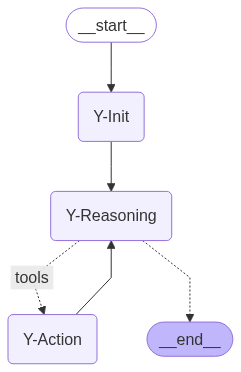

In [7]:
from IPython.display import Image, display
display(Image(y_agent.graph.get_graph().draw_mermaid_png()))

In [51]:
# state = GlobalState(user_request="こんにちは。")
# state = GlobalState(user_request="5*(2+3)を計算し、その結果を'calculate.txt'に書き込んで保存してください。")
state = GlobalState(user_request="ダイエット管理アプリの要件定義書を作成し、markdown形式のファイルに保存してください。要件定義書には、想定ユーザ、アプリ機能一覧、制約事項が含まれている必要があります。")

y_agent.run(state)

y_agent.run_log["messages"]

Initialization
text='\nユーザの要求に対して思考と行動を行ってください。\nユーザの要求：`ダイエット管理アプリの要件定義書を作成し、markdown形式のファイルに保存してください。要件定義書には、想定ユーザ、アプリ機能一覧、制約事項が含まれている必要があります。`\n'
Y-Reasoning now... 思考1回目
```
質問：ダイエット管理アプリの要件定義書を作成し、markdown形式のファイルに保存してください。要件定義書には、想定ユーザ、アプリ機能一覧、制約事項が含まれている必要があります。
思考：まず、ダイエット管理アプリの要件定義書の内容を考え、作成する必要があります。次に、その内容をmarkdown形式でファイルに保存します。
行動：要件定義書の内容を作成する
行動の入力：ダイエット管理アプリの要件定義書の内容を考える
```

ダイエット管理アプリの要件定義書の内容を以下に示します。

---

# ダイエット管理アプリ 要件定義書

## 1. 想定ユーザ
- 健康的に体重を減らしたいと考えている成人
- 食事や運動の記録を手軽に行いたい人
- ダイエットの進捗を視覚的に確認したい人

## 2. アプリ機能一覧
- ユーザ登録・ログイン機能
- 食事記録機能
  - 食品名、カロリー、摂取時間の記録
- 運動記録機能
  - 運動内容、消費カロリー、運動時間の記録
- 体重記録機能
  - 日々の体重を記録し、グラフで表示
- ダッシュボード機能
  - 目標体重までの進捗状況を表示
- 通知機能
  - 食事や運動の記録を促すリマインダー
- レポート機能
  - 週次・月次のダイエット進捗レポートを生成

## 3. 制約事項
- iOSおよびAndroidの両OSに対応すること
- ユーザデータはクラウド上に安全に保存されること
- プライバシーポリシーに基づき、ユーザデータの取り扱いに注意すること

---

次に、この内容をmarkdown形式のファイルに保存します。


[SystemMessage(content='\nあなたは優秀なAIエージェントです。\n', additional_kwargs={}, response_metadata={}, id='6c0bbc6e-8eda-4ed3-885f-8a5ee63d515a'),
 HumanMessage(content='\nユーザの要求に対して思考と行動を行ってください。\nユーザの要求：`ダイエット管理アプリの要件定義書を作成し、markdown形式のファイルに保存してください。要件定義書には、想定ユーザ、アプリ機能一覧、制約事項が含まれている必要があります。`\n', additional_kwargs={}, response_metadata={}, id='d7eb94ff-808f-4b60-9709-28d0f47d00ac'),
 HumanMessage(content='\nまずは最初に取るべき行動を思考し、行動を実行してください。\n思考の結果は以下の形式で提示してください。\n```\n質問：ユーザの要望\n思考：最初の行動の計画\n行動：実行すべきアクション。ツールがあれば使用する\n行動の入力：アクションへの入力\n```\n', additional_kwargs={}, response_metadata={}, id='95fe8094-89de-4181-9597-5a9a3911f662'),
 AIMessage(content='```\n質問：ダイエット管理アプリの要件定義書を作成し、markdown形式のファイルに保存してください。要件定義書には、想定ユーザ、アプリ機能一覧、制約事項が含まれている必要があります。\n思考：まず、ダイエット管理アプリの要件定義書の内容を考え、作成する必要があります。次に、その内容をmarkdown形式でファイルに保存します。\n行動：要件定義書の内容を作成する\n行動の入力：ダイエット管理アプリの要件定義書の内容を考える\n```\n\nダイエット管理アプリの要件定義書の内容を以下に示します。\n\n---\n\n# ダイエット管理アプリ 要件定義書\n\n## 1. 想定ユーザ\n- 健康的に体重を減らしたいと考えている成人\n- 食事や運動の記録を手軽に行いたい人\n- ダイエットの進捗

In [52]:
print(y_agent.first_thought.content)

```
質問：ダイエット管理アプリの要件定義書を作成し、markdown形式のファイルに保存してください。要件定義書には、想定ユーザ、アプリ機能一覧、制約事項が含まれている必要があります。
思考：まず、ダイエット管理アプリの要件定義書の内容を考え、作成する必要があります。次に、その内容をmarkdown形式でファイルに保存します。
行動：要件定義書の内容を作成する
行動の入力：ダイエット管理アプリの要件定義書の内容を考える
```

ダイエット管理アプリの要件定義書の内容を以下に示します。

---

# ダイエット管理アプリ 要件定義書

## 1. 想定ユーザ
- 健康的に体重を減らしたいと考えている成人
- 食事や運動の記録を手軽に行いたい人
- ダイエットの進捗を視覚的に確認したい人

## 2. アプリ機能一覧
- ユーザ登録・ログイン機能
- 食事記録機能
  - 食品名、カロリー、摂取時間の記録
- 運動記録機能
  - 運動内容、消費カロリー、運動時間の記録
- 体重記録機能
  - 日々の体重を記録し、グラフで表示
- ダッシュボード機能
  - 目標体重までの進捗状況を表示
- 通知機能
  - 食事や運動の記録を促すリマインダー
- レポート機能
  - 週次・月次のダイエット進捗レポートを生成

## 3. 制約事項
- iOSおよびAndroidの両OSに対応すること
- ユーザデータはクラウド上に安全に保存されること
- プライバシーポリシーに基づき、ユーザデータの取り扱いに注意すること

---

次に、この内容をmarkdown形式のファイルに保存します。
